# Localization using Particle Filters

The goal of this notebook is to implement simple Particle Filter in python, and visualize robot localization. This is not all inclusive material, however I have tried to informally explain core concepts as well as some intuitions around it. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time

%matplotlib inline

In [2]:
class Robot:
    '''
    x, y: 2d world locations
    orientation: robot orientation in radians
    forward_noise: uncertainty in forward motion
    turn_noise: uncertainty in turning
    sense_noise: uncertainty in sensor readings
    '''
    def __init__(self):
        self.x = np.random.random() * g_environment["world_size"]
        self.y = np.random.random() * g_environment["world_size"]
        self.orientation = np.random.random() * 2.0 * np.pi
        self.forward_noise = 1e-100;
        self.turn_noise    = 1e-100;
        self.sense_noise   = 1e-100;
    
    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= g_environment["world_size"]:
            raise ValueError, 'X coordinate out of bound'
        if new_y < 0 or new_y >= g_environment["world_size"]:
            raise ValueError, 'Y coordinate out of bound'
        if new_orientation < 0 or new_orientation >= 2 * np.pi:
            raise ValueError, 'Orientation must be in [0..2np.pi]'
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)
    
    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);
    
    def sense(self):
        Z = []
        for i in range(len(g_environment["landmarks"])):
            dist = np.sqrt((self.x - g_environment["landmarks"][i][0]) ** 2 \
                            + (self.y - g_environment["landmarks"][i][1]) ** 2)
            dist += np.random.normal(0.0, self.sense_noise)
            Z.append(dist)
        return Z
    
    def move(self, turn, forward):
        if forward < 0:
            raise ValueError, 'Robot cant move backwards'         
        
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + np.random.normal(0.0, self.turn_noise)
        orientation %= 2 * np.pi
        
        # move, and add randomness to the motion command
        dist = float(forward) + np.random.normal(0.0, self.forward_noise)
        x = self.x + (np.cos(orientation) * dist)
        y = self.y + (np.sin(orientation) * dist)
        x %= g_environment["world_size"]    # cyclic truncate
        y %= g_environment["world_size"]
        
        # set particle
        res = Robot()
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res
    
    def Gaussian(self, mu, sigma, x):
        
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return np.exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / np.sqrt(2.0 * np.pi * (sigma ** 2))
      
    def measurement_prob(self, measurement):
        
        # calculates how likely a measurement should be
        
        prob = 1.0;
        for i in range(len(g_environment["landmarks"])):
            dist = np.sqrt((self.x - g_environment["landmarks"][i][0]) ** 2 \
                               + (self.y - g_environment["landmarks"][i][1]) ** 2)
            prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
        return prob
      
    def __repr__(self):
        return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.orientation))

def eval(r, p):
    sum = 0.0;
    world_size = g_environment["world_size"]
    for i in range(len(p)): # calculate mean error
        dx = (p[i].x - r.x + (world_size/2.0)) % world_size - (world_size/2.0)
        dy = (p[i].y - r.y + (world_size/2.0)) % world_size - (world_size/2.0)
        err = np.sqrt(dx * dx + dy * dy)
        sum += err
    return sum / float(len(p))

In [3]:
def plot_curr_state(environment, robot_t, particles_t=None):
    
    # landmarks
    for lm in environment["landmarks"]:
        plt.plot(lm[0], lm[1], c="y", marker="o", zorder=0, markersize=20)
        plt.plot(lm[0], lm[1], c="b", marker="*", zorder=0, markersize=20)
    
    # particles
    if particles_t:
        for p in particles_t:
            plt.plot(p.x, p.y, marker=(4, 0, p.orientation*180/np.pi+45), 
                                             c="skyblue", alpha=0.3, zorder=1, markersize=15)
            plt.plot(p.x, p.y, marker=(3, 0, p.orientation*180/np.pi-90), 
                                             c="steelblue", alpha=0.3, zorder=1, markersize=10)
        
        # particle estimation
        mu_x, mu_y = np.array([(p.x, p.y, p.orientation) for p in particles])[:,0:2].mean(axis=0)
        plt.plot(mu_x, mu_y, c="steelblue", alpha=1.0, \
                                 marker=(4, 0, robot_t.orientation*180/np.pi+45), zorder=2, markersize=25)
        plt.plot(mu_x, mu_y, c="yellow", alpha=1.0, \
                                 marker=(3, 0, robot_t.orientation*180/np.pi-90), zorder=2, markersize=22)
        plt.plot(mu_x, mu_y, c="k", marker='.', zorder=2)
    
    # robot
    if robot_t:
        plt.plot(robot_t.x, robot_t.y, c="g", alpha=1.0,
                                marker=(4, 0, 45+robot_t.orientation*180/np.pi), zorder=5, markersize=30)
        plt.plot(robot_t.x, robot_t.y, c="lime", alpha=1.0, 
                                marker=(3, 0, robot_t.orientation*180/np.pi-90), zorder=5, markersize=30)
        plt.plot(robot_t.x, robot_t.y, c="k", marker='.', zorder=7)

    plt.xlim([0, environment["world_size"]])
    plt.ylim([0, environment["world_size"]])
    plt.tight_layout()
    plt.rcParams.update({'font.size':16})

## Environment

In [4]:
# Environment parameters
g_environment = { 
    # "landmarks": [[30.0, 30.0], [170.0, 70.0], [40.0, 170.0], [160.0, 130.0]], 
    "landmarks": [[30.0, 30.0], [170.0, 30.0], [30.0, 170.0], [170.0, 170.0]], 
    "world_size": 200.0 
}

sensor_noise = 20.0 # this is quite large compared to the world size
turning_noise, forward_noise = 0.08, 0.1

## Our lost Robot

Let's create a Robot object representing a target that we want to localize.

In [5]:
myrobot = Robot()

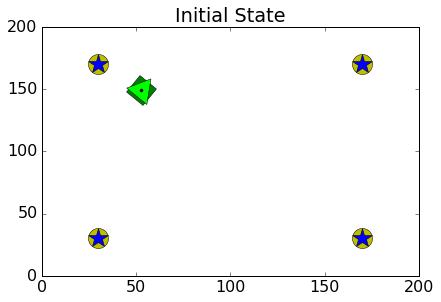

In [6]:
plot_curr_state(g_environment, myrobot)
plt.title("Initial State")

## Localization

The goal of the localization is to pin point robot's location as well as pose in the world coordinate system using least amount of resources and time. In this experiment, we will apply Particle Filter algorithm to localize the robot.

The robot is intialized with random location and pose. We make practical assumption that robot's motion and measurement are noisy and the nature of noise to be gaussian with zero mean. In each iteration, we apply motion commands, sense the environment to make measurement (distance from landmarks) and continue.

## Particle Filter

Each particle in Particle Filter represents a probable location and pose of the target robot. During initialization, we distribute a constant (N) amount of particles uniformaly at random. This amounts to the complete uncertainty about robot location in the beginning.

As the robot makes its first observation, we compute measurement probabilty for each particle. For example, if the robot started at the center, then it is less likely that particles sitting at right end would make similar observations (given that measurement uncertainty is not crazily high). You can imagine further steps as a survival game in which only those particles get to survive which closely represent our robot's location and pose. However, doing so will decrease its population over time. Therefore, we don't kill the rest of the particles. Instead, we resample same amount of particles, however, this time they aren't sampled uniformaly at random. We now have gained some knowledge about robot location and pose (by measuring measurement probability for each particle). We use that knowledge to define our new sampling distribution. The benefits are twofold: to maintain a constant amount of particles as well as to improve precision as we progress. 

Before we resample, we assign weights to all the particles depending on how closely they are related to the actual robot's location and pose. Then during resampling, we sample particles according to their weights. The higher the weight, the more chance of being sampled. We use Resampling Wheel Algorithm for this purpose. After few resampling, we can clearly see that the new particle's density is directly proportional to the measurement probability, so we see more particles around the actual robot then away from it.

### Initialization

In [7]:
# Create particles
N = 400
particles = []
for i in range(N):
    r = Robot()
    # set uncertainty in motion (turn/forward) and sensor readings
    r.set_noise(forward_noise, turning_noise, sensor_noise) 
    particles.append(r)

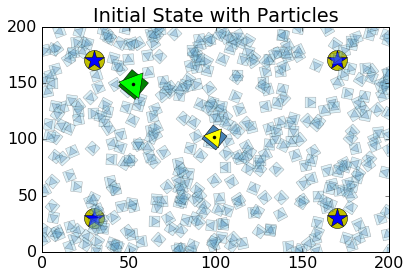

In [8]:
plot_curr_state(g_environment, myrobot, particles)
plt.title("Initial State with Particles")

### Move-Sense loop until localized (converged to a good solution)

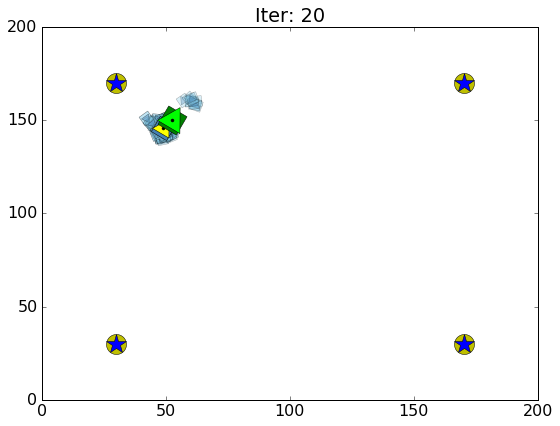

RMSE:  6.26086132641


In [9]:
# We assume there is no external force involved, and there is a constant motion
motion = (1.0, 5.0) # (turn, forward) 

eval_hist = []
iter_no = 0
# particle_std_thr = sensor_noise
# particle_std = float('inf')

plt.figure(figsize=(8,6))

for i in range(20):
    
    iter_no += 1
    
    # Plot current state of the environment, our robot, and particles
    plt.gca().cla()
    plot_curr_state(g_environment, myrobot, particles)
    plt.title("Iter: {}".format(iter_no))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    # Move (move the actual robot) - increases uncertainty
    myrobot = myrobot.move(*motion)
    
    # Measurement (here, we will measure the actual distance of the robot from all the landmarks)
    # - reduces uncertainty
    Z = myrobot.sense()
    
    p2 = []
    for i in range(N):
        # For each particle, we apply the same motion 
        # Remember that these particles will have uncertainty in the motion
        p2.append(particles[i].move(*motion))
    particles = p2
    
    w = []
    for i in range(N):
        # For each particle, we calculate how likely is the measurement that we got from actual 
        # robot given the particle's location (we ignore the orientation for the simplicity)
        # For example, if the robot is at the center of the world, then it is less likely that 
        # a particle sitting at the corner would make the same measurement (assuming our measurement 
        # uncertainty is not crazily high)
        # We store this probability as weights. The closer the particle to the actual robot, 
        # the higher the weight it will be assigned.
        w.append(particles[i].measurement_prob(Z))

    # Resampling wheel algorithm 
    # We will resample particles according to their weights in order to get partilces
    # which are more likely to be in proximity of our target robot in both spatial and pose dimension.
    p3 = []
    index = int(np.random.random() * N)
    beta = 0.0
    mw = max(w)
    for i in range(N):
        beta += np.random.random() * 2.0 * mw
        while beta > w[index]:
            beta -= w[index]
            index = (index + 1) % N
            
        p3.append(particles[index])
    particles = p3
    
    rmse = eval(myrobot,particles)
    print "RMSE: ", rmse
    eval_hist.append(rmse)
    
    # x_std, y_std = np.array([(p.x, p.y, p.orientation) for p in particles])[:,0:2].std(axis=0)
    # particle_std = x_std*y_std
#     time.sleep(0.5)
plt.clf()
# print "RMSE log: ", eval_hist

In [10]:
particles_array = np.array([(p.x, p.y, p.orientation) for p in particles])
print "Robot location: ({},{}), pose:{}".format(myrobot.x, myrobot.y, myrobot.orientation)
print "Estimated location: ({},{}), pose:{}".format(
            particles_array[:,0].mean(), particles_array[:,1].mean(), particles_array[:,2].mean())

Robot location: (50.4752363921,154.594048631), pose:2.03741567816
Estimated location: (47.3808709278,150.207610964), pose:1.94894360982


### Performance 
(lower RMSE is better)

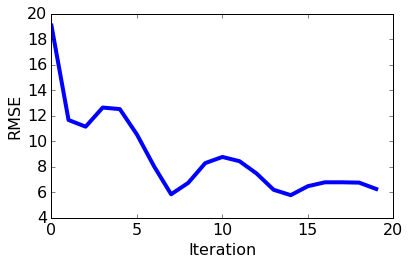

In [11]:
plt.plot(eval_hist, linewidth=4)
plt.ylabel("RMSE")
plt.xlabel("Iteration")
plt.tight_layout()
plt.rcParams.update({'font.size':16})

## References

[1] https://www.udacity.com/course/artificial-intelligence-for-robotics--cs373

[2] http://matplotlib.org/

Special Thanks to [Sebastian Thrun](http://robots.stanford.edu/) for providing many resources!